# Overview #

## Project Info ##

- Developed by: Sean Pritchard
- for: CSCA 5642: Introduction to Deep Learning
- URL: https://github.com/seanpritchard94/deep-learning-name-correction
- Data Source: https://www.ssa.gov/oact/babynames/names.zip (Social Security Administration, 2025b)
- Python version: 3.12

## Data Collection and Provenance ##

The Social Security Administration (a division of the U.S. Government) provides comprehensive data on the names given to babies going back to 1880. This list is not completely exhaustive. They note:

> To safeguard privacy, we exclude from these files certain names that would indicate, or would allow the ability to determine, names with fewer than 5 occurrences in any geographic area. (Social Security Administration, 2025b)

Because I am using the national list, it means that names given to fewer than five boys or five girls will be omitted from that year's data. Even with this limitation, the dataset contains over 100,000 names and provides a rich source of information on given names assigned to babies in the U.S.

It is also important to realize that the older data is incomplete
> All names are from Social Security card applications for births that occurred in the United States after 1879. Note that many people born before 1937 never applied for a Social Security card, so their names are not included in our data. For others who did apply, our records may not show the place of birth, and again their names are not included in our data.
> All data are from a 100% sample of our records on Social Security card applications as of March 2025 (Social Security Administration, 2025a)

Because this data is based on the names of babies born in the United States, it skews heavily towards traditional American names. Models trained on this data may not perform well on names from other countries. But it should be possible to apply the same approach using a name list from another country, region, or culture.

## Problem Description ##

Identity Resolution is the process of determining when two electronic records belong to the same person. Or alternately, it is the process of determining who a given electronic record refers to.

Almost all businesses have multiple databases that contain customer information. Errors in data make it difficult to link data across these databases. Errors in data also lead to duplicates within a given database.

In some industries, such as healthcare, the failure to link records and the presence of duplicate records can lead to disastrous consequences such as a patient experiencing a life-threatening drug interaction that was not identified due to incomplete and unlinked records.

In all industries, duplicate and unlinked records lead to bad customer experiences and hurt a company's reputation with its customers.

## Data Description ##

The data is provided in many files (one per year from 1880-2024). Each file contains 3 columns: Name, gender, count. For names assigned to both boys and girls (such as Taylor) there may be two rows for that name in a year. For names assigned to only one gender, there will be one row. Not all names appear in all rows. Some names (such as Ichabod) have fallen out of favor and appear only in files representing data from earlier years.

After aggregating these names, but prior to cleaning, the data set contains 104819 unique names.

The SSA publishes some important details about the data
> Data qualifications
> People using our data on popular names are urged to explicitly acknowledge the following qualifications.
> 1. Names are restricted to cases where the year of birth, sex, and state of birth are on record, and where the given name is at least 2 characters long.
> 2. National name data is restricted to births in the 50 States and District of Columbia. We also provide popular names for births in U. S. territories (American Samoa, Guam, Northern Mariana Islands, Puerto Rico and the U.S. Virgin Islands). The data on births in U. S. territories are not included in our national data.
> 3. Name data are tabulated from the "First Name" field of the Social Security Card Application. Hyphens and spaces are removed, thus Julie-Anne, Julie Anne, and Julieanne will be counted as a single entry.
> 4. Name data are not edited. For example, the sex associated with a name may be incorrect. Entries such as "Unknown" and "Baby" are not removed from the lists.
> 5. Different spellings of similar names are not combined. For example, the names Caitlin, Caitlyn, Kaitlin, Kaitlyn, Kaitlynn, Katelyn, and Katelynn are considered separate names and each has its own rank.
> 6. When two different names are tied with the same frequency for a given year of birth, we break the tie by assigning rank in alphabetical order.
> 7. Some names are applied to both males and females (for example, Micah). Our rankings are done by sex, so that a name such as Micah will have a different rank for males as compared to females. When you seek the popularity of a specific name (see "Popularity of a Name"), you can specify the sex. If you do not specify the sex, we provide rankings for the more popular name-sex combination.
> 8. To safeguard privacy, we exclude from our tabulated lists of names those that would indicate, or would allow the ability to determine, names with fewer than 5 occurrences in any geographic area. If a name has less than 5 occurrences for a year of birth in any state, the sum of the state counts for that year will be less than the national count.
> (Social Security Administration, 2025a)

In [1]:
import os

#turn down tensorflow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import gc

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import warnings
import random
import string
from wordcloud import WordCloud
warnings.filterwarnings('ignore')


%matplotlib inline

# Exploratory Data Analysis #

## Data Loading and Cleaning ##
Because the data is distributed over 144 files and names appear multiple times in a file if they are given to boys and girls, we will read all files into a dataframe and then group by name to get the total count.

This code assumes you have downloaded names.zip from the SSA and extracted it to the names directory.


In [54]:
# List all txt files in names directory
files = [f for f in os.listdir('names') if f.endswith('.txt') and f.startswith('yob')]

# Read and concatenate all dataframes
all_dfs = []
for file in files:
    df = pd.read_csv(f'names/{file}', header=None, names=['name', 'gender', 'count'])
    all_dfs.append(df)

combined_df = pd.concat(all_dfs, ignore_index=True)

combined_df['name'] = combined_df['name'].str.lower()

# Group by name and sum counts
aggregated_df = combined_df.groupby('name')['count'].sum().reset_index().sort_values('count', ascending=False)

# Display the result
print(aggregated_df.head())


          name    count
41683    james  5262396
46213     john  5196210
80781   robert  4866007
67796  michael  4440391
99966  william  4205026


In [4]:
print(len(aggregated_df))

104819


## Data Exploration and Visualization ##

The first chart shows that the top ranked (most common) names on the left of the chart have very high counts (y is in a log scale). The top few names have frequency counts in the hundreds of thousands, or even millions.

The counts drop quickly as we head towards less common names. The 20,000th name on the list (still in the top 20% most common) appears less than 1000 times. Around the 40,000th name on the list (the edge of the 40% most common names) the name has only been used 100 times since 1880! The least common 60,000 names have all been used less than 100 times.


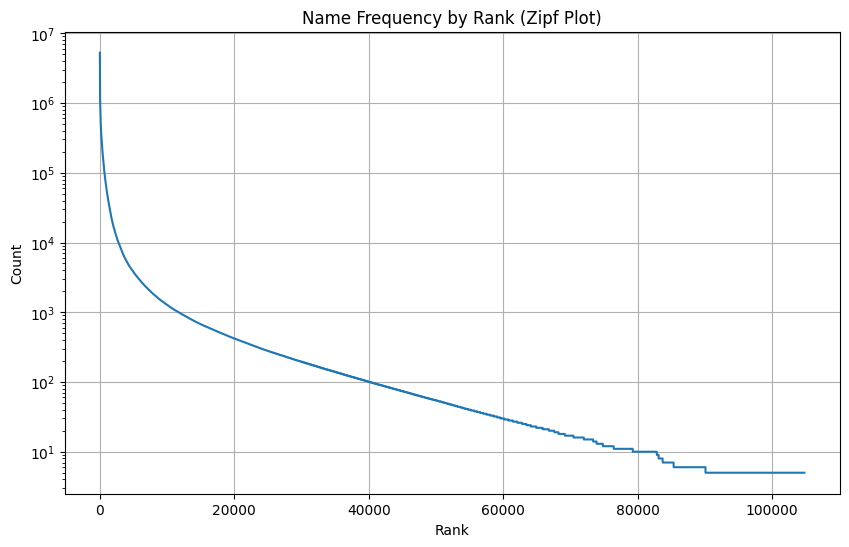

In [5]:
sorted_counts = aggregated_df.sort_values('count', ascending=False)['count']
plt.figure(figsize=(10,6))
plt.semilogy(range(1, len(sorted_counts)+1), sorted_counts.values)
plt.xlabel('Rank')
plt.ylabel('Count')
plt.title('Name Frequency by Rank (Zipf Plot)')
plt.grid(True)
plt.show()


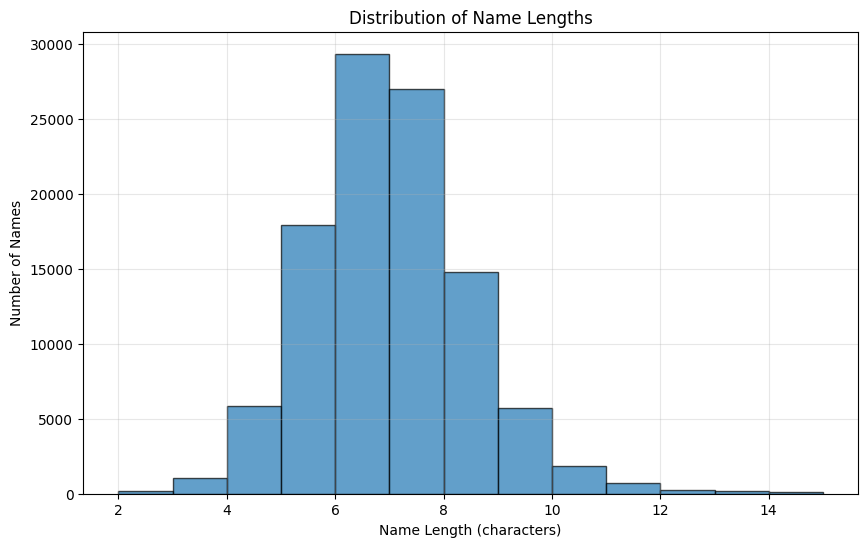

In [56]:

aggregated_df['name_length'] = aggregated_df['name'].str.len()

plt.figure(figsize=(10,6))
plt.hist(aggregated_df['name_length'], bins=range(aggregated_df['name_length'].min(), aggregated_df['name_length'].max()+1), alpha=0.7, edgecolor='black')
plt.xlabel('Name Length (characters)')
plt.ylabel('Number of Names')
plt.title('Distribution of Name Lengths')
plt.grid(True, alpha=0.3)
plt.show()


### Wordclouds ###
The two word clouds below help us visualize the most common names (the first cloud) and then the 100 names near the middle of the list of most to least common. The second cloud has some names we recognize and some we might not. Even so, they are generally recognizable as names which is encouraging. Names follow some unknown set of rules and when we inject noise, we should have something that looks different from a normal name.

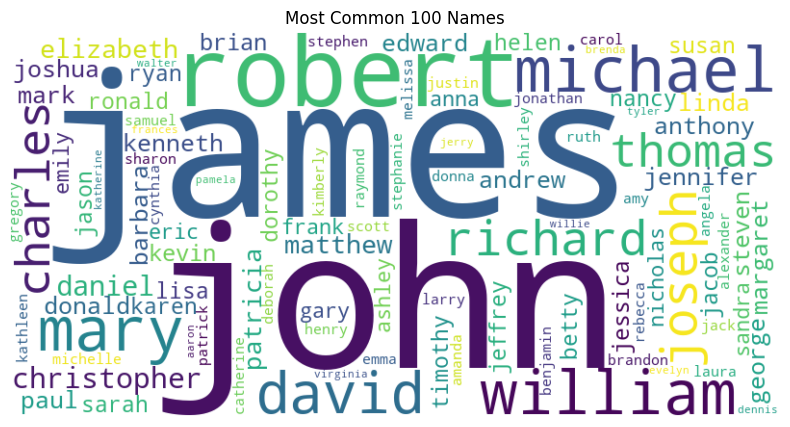

In [10]:
sorted_df = aggregated_df.sort_values('count', ascending=False)
top_100 = sorted_df.head(100)

# Create frequency dict
top_freq = dict(zip(top_100['name'], top_100['count']))

wordcloud_top = WordCloud(width=800, height=400, background_color='white')
wordcloud_top.generate_from_frequencies(top_freq)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_top, interpolation='bilinear')
plt.title('Most Common 100 Names')
plt.axis('off')
plt.show()


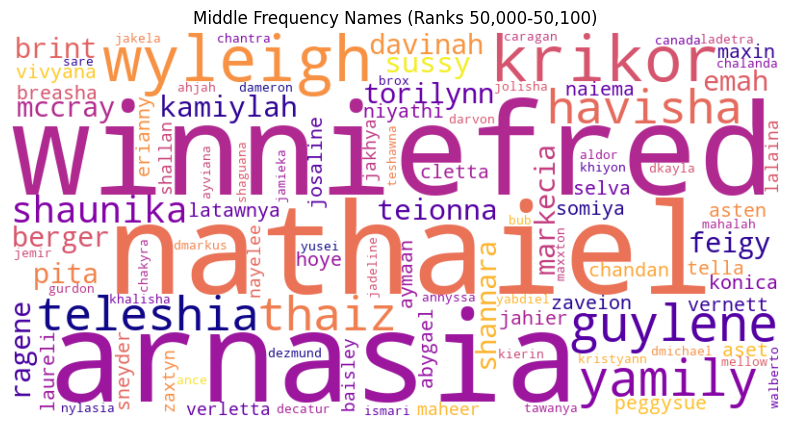

In [9]:
middle_100 = sorted_df.iloc[50000:50100]
middle_freq = dict(zip(middle_100['name'], middle_100['count']))

wordcloud_middle = WordCloud(width=800, height=400, background_color='white', colormap='plasma')
wordcloud_middle.generate_from_frequencies(middle_freq)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_middle, interpolation='bilinear')
plt.title('Middle Frequency Names (Ranks 50,000-50,100)')
plt.axis('off')
plt.show()


## Plan of Analysis ##

Because order is critical in the sequence of characters that make up a name, the problem is well-suited for Recurrent Neural Networks (RNN). I will use RNNs to build a Denoising Autoencoder.

I wil have to split my data into test, train, and validation sets and then generate pairs of names and random noise. Then I will attempt to train a Denoising Autoencoder to remove the noise.


## Data Preparation ##

For this project, I need to add noise to the original data. Before adding noise, I will split the data to test, validation, and test sets in an 80/10/10 ratio.

Then, for each name I will generate 1-3 random noise errors. (Shorter names will have only 1 or two errors depending on name length). The types of errors include:
- transposition: transpose adjacent character
- substitution: replace character with adjacent key
- deletion: skip a character
- duplicate_insertion: duplicate a character by mistake
- adjacent_key_insertion: Adding an adjacent key

I will generate train, test, and validation noise data sets by repeately iterating over the names and adding random noise.

It is also necessary to convert the strings to numbers including special *start of sequence* and *end of sequence* tokens.

In [57]:
#split out a train and a combined test/validation set
train_df, test_val_df = train_test_split(aggregated_df, test_size=0.2, random_state=42)
#split out test and validation
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

data_names_path = 'data/names'
os.makedirs(data_names_path, exist_ok=True)
train_df.drop(columns=['count','name_length'], inplace=True)
test_df.drop(columns=['count','name_length'], inplace=True)
val_df.drop(columns=['count','name_length'], inplace=True)

train_df.to_csv(f'{data_names_path}/train_names.csv', index=False)
test_df.to_csv(f'{data_names_path}/test_names.csv', index=False)
val_df.to_csv(f'{data_names_path}/val_names.csv', index=False)
aggregated_df.to_csv(f'{data_names_path}/aggregated_names.csv', index=False)

print(f"train count: {len(train_df)}, test count: {len(test_df)}, validation count: {len(val_df)}")

train count: 83855, test count: 10482, validation count: 10482


In [61]:

#QWERTY ADJACENCY MAP
ADJACENCY_MAP = {
    # Top Row
    'q': ['w', 'a', '1', '2'],
    'w': ['q', 'e', 'a', 's', '2', '3'],
    'e': ['w', 'r', 's', 'd', '3', '4'],
    'r': ['e', 't', 'd', 'f', '4', '5'],
    't': ['r', 'y', 'f', 'g', '5', '6'],
    'y': ['t', 'u', 'g', 'h', '6', '7'],
    'u': ['y', 'i', 'h', 'j', '7', '8'],
    'i': ['u', 'o', 'j', 'k', '8', '9'],
    'o': ['i', 'p', 'k', 'l', '9', '0'],
    'p': ['o', 'l', '0', '-'],

    # Second Row
    'a': ['q', 'w', 's', 'z'],
    's': ['a', 'w', 'e', 'd', 'z', 'x'],
    'd': ['s', 'e', 'r', 'f', 'x', 'c'],
    'f': ['d', 'r', 't', 'g', 'c', 'v'],
    'g': ['f', 't', 'y', 'h', 'v', 'b'],
    'h': ['g', 'y', 'u', 'j', 'b', 'n'],
    'j': ['h', 'u', 'i', 'k', 'n', 'm'],
    'k': ['j', 'i', 'o', 'l', 'm', '/'],
    'l': ['k', 'o', 'p', ';', "'"],

    # Third Row
    'z': ['a', 's', 'x'],
    'x': ['z', 's', 'd', 'c'],
    'c': ['x', 'd', 'f', 'v'],
    'v': ['c', 'f', 'g', 'b'],
    'b': ['v', 'g', 'h', 'n', ' '],
    'n': ['b', 'h', 'j', 'm', ' '],
    'm': ['n', 'j', 'k', ' '],

}

# Define the probability distribution for error types
#these are based on a best guess of how common they are
ERROR_PROBABILITIES = {
    "transposition": 0.35,  # transpose adjacent character
    "substitution": 0.35,   # replace character with adjacent key
    "deletion": 0.15,       # skip a character
    "duplicate_insertion": 0.10, # duplicate a character by mistake
    "adjacent_key_insertion": 0.05 # Adding an adjacent key
}

def find_adjacent_keys(char: str) -> list[str]:
    """Returns a list of adjacent keys on a standard QWERTY keyboard."""
    if not char:
        return []

    key = char.lower()
    return ADJACENCY_MAP.get(key, [])

def get_biased_index(n: int) -> int:
    """
    Returns a random index from 0 to n-1, implemented as function in
    case we want to add bias to the ends of the string
    """
    if n <= 1:
        return 0

    return random.randrange(0, n - 1)


def add_typing_noise(word: str, max_len: int = 15, min_len: int = 2) -> str:
    """
    Applies 1 to 3 typing noise operations to a word using decaying probability,
    ensuring length constraints are respected.
    """
    if not word or len(word) < min_len:
        return word

    s = list(word.lower())
    n = len(s)

    if n >= 10:
        max_possible_errors = 3
        weights = [0.6, 0.3, 0.1]  # 60/30/10
    elif n >= 7:
        max_possible_errors = 3
        weights = [0.75, 0.20, 0.05] # 75/20/5 (for 7-9 char names)
    elif n >= 2:
        max_possible_errors = 2
        weights = [0.85, 0.15] # 85/15 (Max 2 errors for 2-6 char names)
    else:
        return word # Handle extremely short names

    choices = [1, 2, 3][:max_possible_errors]
    weights = weights[:max_possible_errors]

    if not choices:
        return word # Should not happen if n >= 2

    #Normalize weights for random.choices if truncated
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]

    num_errors = random.choices(choices, weights=weights, k=1)[0]

    for _ in range(num_errors):
        n = len(s)
        if n < min_len or n > max_len: break

        allowed_errors = []

        #Transposition/Substitution
        allowed_errors.extend(["transposition", "substitution"])

        #Deletion (Prevent if it would drop length below min_len)
        if n > min_len:
            allowed_errors.append("deletion")

        #Insertion (Prevent if it would exceed max_len)
        if n < max_len:
            allowed_errors.extend(["duplicate_insertion", "adjacent_key_insertion"])

        if not allowed_errors:
            break

        #Weighted selection of the error type
        weights = [ERROR_PROBABILITIES[e] for e in allowed_errors]
        total_weight = sum(weights)
        weights = [w / total_weight for w in weights] # Re-normalize weights

        error = random.choices(allowed_errors, weights=weights, k=1)[0]

        #Apply Error
        if error == "transposition":
            #Transposing adjacent characters
            i = get_biased_index(n - 1)
            s[i], s[i+1] = s[i+1], s[i]

        elif error == "substitution":
            #Replacing a character with an adjacent key
            i = get_biased_index(n)
            char_to_replace = s[i]

            neighbors = find_adjacent_keys(char_to_replace)
            if neighbors:
                s[i] = random.choice(neighbors)

        elif error == "duplicate_insertion":
            #Adding an adjacent duplicate of a character
            i = get_biased_index(n + 1)
            # Ensure i is a valid index for selecting the character to duplicate
            char_to_duplicate = s[random.randrange(n)]
            s.insert(i, char_to_duplicate)

        elif error == "deletion":
            #Removing a character from the string
            i = get_biased_index(n)
            del s[i]

        elif error == "adjacent_key_insertion":
            #Adding a character that is an adjacent key
            i = get_biased_index(n + 1)

            # Determine candidate characters for neighbor selection (before and after insertion point)
            candidate_chars = []
            if i < n: # Look at character *after* insertion point
                candidate_chars.append(s[i])
            if i > 0: # Look at character *before* insertion point
                candidate_chars.append(s[i-1])

            if candidate_chars:
                source_char = random.choice(candidate_chars)
                neighbors = find_adjacent_keys(source_char)

                if neighbors:
                    # Filter out the source character itself to ensure it's a *new* adjacent key
                    valid_neighbors = [k for k in neighbors if k != source_char]
                    if valid_neighbors:
                        s.insert(i, random.choice(valid_neighbors))

    return "".join(s)


names = ["christopher", "jennifer", "george", "catherine", "robert"]
typos = [(name, add_typing_noise(name)) for name in names for _ in range(5)]

print("--- Example Name Correction Pairs ---")
for original, noisy in typos:
    print(f"Original: {original:<12} -> Noisy: {noisy}")

--- Example Name Correction Pairs ---
Original: christopher  -> Noisy: chrixtopher
Original: christopher  -> Noisy: christohper
Original: christopher  -> Noisy: christoper
Original: christopher  -> Noisy: christophr
Original: christopher  -> Noisy: chortsopher
Original: jennifer     -> Noisy: jenniefr
Original: jennifer     -> Noisy: jeninfenr
Original: jennifer     -> Noisy: jenhifer
Original: jennifer     -> Noisy: jennier
Original: jennifer     -> Noisy: jehnifer
Original: george       -> Noisy: ogrge
Original: george       -> Noisy: geogre
Original: george       -> Noisy: egorge
Original: george       -> Noisy: geroge
Original: george       -> Noisy: yoeorge
Original: catherine    -> Noisy: catheribe
Original: catherine    -> Noisy: catehrine
Original: catherine    -> Noisy: catehirne
Original: catherine    -> Noisy: ctherine
Original: catherine    -> Noisy: atyerine
Original: robert       -> Noisy: r5robert
Original: robert       -> Noisy: robdrt
Original: robert       -> Noisy: r

In [64]:
#genrate pairs of names and noise

def generate_noise(name_df: pd.DataFrame) -> pd.DataFrame:
    """
    accepts a dataframe containing a column of 'name'
    adds a 'noise' column to the dataframe and populates it
    by calling add_typing_noise()
    """
    name_df['noise'] = name_df['name'].apply(add_typing_noise)
    return name_df

def generate_noise_to_file(name_df: pd.DataFrame, path: str, file_name: str, iterations: int) -> pd.DataFrame:
    """
    accepts a dataframe containing a column of 'name'
    adds a 'noise' column to the dataframe and populates it
    by calling add_typing_noise(). Iterates 'ietrations' times and
    the saves the file to path with file_name.
    """
    all_noise_dfs = []
    for i in range(iterations):
        noise_df = generate_noise(name_df.copy())
        all_noise_dfs.append(noise_df)

    combined_noise_df = pd.concat(all_noise_dfs, ignore_index=True)

    os.makedirs(path, exist_ok=True)
    combined_noise_df.to_csv(f'{path}/{file_name}', index=False)
    return combined_noise_df

noise_path = 'data/noise'
train_noise_df_sm = generate_noise_to_file(train_df, noise_path, 'train_noise_small.csv', 5)
test_noise_df_sm = generate_noise_to_file(test_df, noise_path, 'test_noise_small.csv', 5)
val_noise_df_sm = generate_noise_to_file(val_df, noise_path, 'val_noise_small.csv', 5)
train_noise_df_lg = generate_noise_to_file(train_df, noise_path, 'train_noise_large.csv', 50)
test_noise_df_lg = generate_noise_to_file(test_df, noise_path, 'test_noise_large.csv', 50)
val_noise_df_lg = generate_noise_to_file(val_df, noise_path, 'val_noise_large.csv', 50)


In [65]:
#calculate the number of distinct characters
all_chars = set()

for df in [train_noise_df_lg, test_noise_df_lg, val_noise_df_lg]:
    if 'name' in df.columns:
        all_chars.update(''.join(df['name'].dropna()))
    if 'noise' in df.columns:
        all_chars.update(''.join(df['noise'].dropna()))

print(f"Total unique chars: {len(all_chars)} - {sorted(all_chars)}")



Total unique chars: 41 - [' ', "'", '-', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Encoding and Decoding Names to Numeric Sequences ###

It is necessary to map all the characters in our data to numerical tokens. It is also important to use start of sequence (SOS), End of Sequence (EOS), and padding (PAD). Tokens. The padding tokens ensure all the input has the same length. The SOS and EOS tokens are a bit more complex. They are used primarily by the decoder to know the boundaries of the target and also to know when to stop generating characters when predicting targets. (Zhang, et al., 2023)

In [2]:
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict

UNIQUE_CHARS = [' ', "'", '-', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
# Special Tokens
PAD_TOKEN = '[PAD]' # Must be index 0 for mask_zero=True
SOS_TOKEN = '[SOS]' # Start of Sequence (Decoder Input)
EOS_TOKEN = '[EOS]' # End of Sequence (Decoder Target)

# 3 special tokens + 41 unique chars = 45
SPECIAL_TOKENS = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]
ALL_CHARS = SPECIAL_TOKENS + UNIQUE_CHARS

# Hyperparameters
VOCAB_SIZE = len(ALL_CHARS)
MAX_LEN = 16

# Create the mappings
CHAR_TO_INDEX: Dict[str, int] = {char: i for i, char in enumerate(ALL_CHARS)}
INDEX_TO_CHAR: Dict[int, str] = {i: char for char, i in CHAR_TO_INDEX.items()}

# Verify token indices (crucial for mask_zero)
PAD_INDEX = CHAR_TO_INDEX[PAD_TOKEN]
SOS_INDEX = CHAR_TO_INDEX[SOS_TOKEN]
EOS_INDEX = CHAR_TO_INDEX[EOS_TOKEN]

def encode_noisy_name(noisy_names: pd.Series) -> np.ndarray:
    """
    Encodes the noisy names for the ENCODER INPUT.
    Encoder input receives the corrupted sequence, padded to MAX_LEN.

    Args:
        noisy_names: A pandas Series of the noisy name strings.

    Returns:
        A NumPy array of shape (num_samples, MAX_LEN).
    """
    encoder_input_data = np.zeros(
        (len(noisy_names), MAX_LEN),
        dtype='int32'
    )

    for i, name in enumerate(noisy_names):
        # We process the name character by character
        for t, char in enumerate(name):
            if t < MAX_LEN:
                # Use the index from the map, defaulting to PAD_INDEX for unknown chars
                encoder_input_data[i, t] = CHAR_TO_INDEX.get(char, PAD_INDEX)
            else:
                break # Truncate if name is longer than MAX_LEN

    return encoder_input_data

def encode_clean_name(clean_names: pd.Series) -> Tuple[np.ndarray, np.ndarray]:
    """
    Encodes the clean names into two targets: DECODER INPUT and DECODER TARGET.

    1. DECODER INPUT (for teacher forcing): Starts with [SOS] and contains the correct name.
    2. DECODER TARGET (labels): Contains the correct name followed by [EOS].

    Args:
        clean_names: A pandas Series of the clean name strings.

    Returns:
        A tuple: (decoder_input_data, decoder_target_data)
    """
    num_samples = len(clean_names)

    # Initialize arrays with padding
    decoder_input_data = np.full(
        (num_samples, MAX_LEN),
        PAD_INDEX,
        dtype='int32'
    )
    decoder_target_data = np.full(
        (num_samples, MAX_LEN),
        PAD_INDEX,
        dtype='int32'
    )

    for i, name in enumerate(clean_names):
        # Ensure name length is capped for safety (MAX_LEN - 1 for EOS/SOS)
        effective_name = name[:MAX_LEN - 1]

        # DECODER INPUT
        # Starts with [SOS], followed by the clean name characters
        decoder_input_data[i, 0] = SOS_INDEX
        for t, char in enumerate(effective_name):
            # Start filling from index 1 (after SOS)
            decoder_input_data[i, t + 1] = CHAR_TO_INDEX.get(char, PAD_INDEX)

        # DECODER TARGET
        # Starts with the clean name characters, followed by [EOS]
        for t, char in enumerate(effective_name):
            # Start filling from index 0
            decoder_target_data[i, t] = CHAR_TO_INDEX.get(char, PAD_INDEX)

        # Add the EOS marker immediately after the last character
        decoder_target_data[i, len(effective_name)] = EOS_INDEX

    return decoder_input_data, decoder_target_data

# DECODING FUNCTION
def decode_output_sequence(output_sequence: np.ndarray) -> str:
    """
    Decodes the model's predicted output sequence of indices back into a clean string.

    Args:
        output_sequence: A 1D NumPy array of character indices predicted by the model.

    Returns:
        The reconstructed name string.
    """
    decoded_name = []

    # Iterate through the predicted indices
    for index in output_sequence:
        char = INDEX_TO_CHAR.get(index, '')

        # Stop decoding if the End-of-Sequence marker is encountered
        if index == EOS_INDEX or index == PAD_INDEX:
            break

        decoded_name.append(char)

    # Join characters, removing any leading/trailing spaces that might have resulted from decoding noise
    return "".join(decoded_name).strip()

# Training Data Preparation and DataFrame Creation
def encode_name_and_noise(name_and_noise_df: pd.DataFrame, path: str, file_name: str) -> pd.DataFrame:
    """
    accepts a dataframe containing column of 'name' and 'noise
    returns a new df that is a copy with X and Y encoded versions
    for use with Seq2Seq encoder and decoder.
    """
    # X_encoder (Noisy Input)
    X_encoder_array = encode_noisy_name(name_and_noise_df['noise'])
    # X_decoder (Teacher Forcing Input) and Y_target (Labels)
    X_decoder_array, Y_target_array = encode_clean_name(name_and_noise_df['name'])
    # Create the new DataFrame
    encoded_data = name_and_noise_df.copy()

    # Convert the NumPy rows back to lists to be stored cleanly in the DataFrame columns
    encoded_data['X_encoder'] = list(X_encoder_array)
    encoded_data['X_decoder'] = list(X_decoder_array)
    encoded_data['Y_target'] = list(Y_target_array)

    os.makedirs(path, exist_ok=True)
    encoded_data.to_csv(f'{path}/{file_name}', index=False)

    return encoded_data



In [ ]:
encoded_path = 'data/encoded'

encoded_train_df_sm = encode_name_and_noise(train_noise_df_sm, encoded_path, 'encoded_train_small.csv')
encoded_test_df_sm = encode_name_and_noise(test_noise_df_sm, encoded_path, 'encoded_test_small.csv')
encoded_val_df_sm = encode_name_and_noise(val_noise_df_sm, encoded_path, 'encoded_val_small.csv')

encoded_train_df_lg = encode_name_and_noise(train_noise_df_lg, encoded_path, 'encoded_train_large.csv')
encoded_test_df_lg = encode_name_and_noise(test_noise_df_lg, encoded_path, 'encoded_test_large.csv')
encoded_val_df_lg = encode_name_and_noise(val_noise_df_lg, encoded_path, 'encoded_val_large.csv')

encoded_train_df_ty = encoded_train_df_sm[:1000]
encoded_test_df_ty = encoded_test_df_sm[:1000]
encoded_val_df_ty = encoded_val_df_sm[:1000]

encoded_train_df_ty.to_csv(f'{encoded_path}/encoded_train_tiny.csv', index=False)
encoded_test_df_ty.to_csv(f'{encoded_path}/encoded_test_tiny.csv', index=False)
encoded_val_df_ty.to_csv(f'{encoded_path}/encoded_val_tiny.csv', index=False)

In [67]:
#free up RAM. We can load the large or small datasets from disk as needed
import gc
del encoded_train_df_sm
del encoded_test_df_sm
del encoded_val_df_sm
del encoded_train_df_lg
del encoded_test_df_lg
del encoded_val_df_lg
del train_noise_df_sm
del test_noise_df_sm
del val_noise_df_sm
del train_noise_df_lg
del test_noise_df_lg
del val_noise_df_lg
del train_df
del test_df
del val_df
del aggregated_df
gc.collect()

82984

# GPU Execution #
- Everything below this can be run separately on GPU hardward such as Google Colab L4.
- The expectation is that all steps above to generate the encoding data have been run
- the data/encoding folder must be zipped and uploaded to Google Drive

In [1]:
import os

#turn down tensorflow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import warnings
import random

warnings.filterwarnings('ignore')


%matplotlib inline

## Model Architecture ##

I will build a Sequence-to-Sequence (Seq2Seq) model with Attention which is a Bi-directional RNN Encoder-Decoder with Attention. This architecture includes the following major components:

- Encoder (Bi-directional RNN): Compress the noisy input vector into a latent representation (dense context vector)
- Decoder (RNN): Reconstructs the target from the latent representation
- Attention Mechanism: Allows the decoder to look back at the relvant parts of the noisy input

Bi-Directional combines the forward and backwards contexts. I expect this will help the model learn the valid patterns of characters in names and distinguish those from noise.

Sequence-to-Sequence architectures were introduced in the paper *Sequence to Sequence Learning with Neural Networks* in 2014. (Sutskever et al., 2014). Sequence-to_Sequence architectures are frequently used for machine learning language translation. (Wikipedia, 2025)

The metrics: 'sparse_categorical_accuracy' and 'sparse_top_k_categorical_accuracy' are used because they measure how many of the characters int eh strings match while ignoring the padding (zeroes). The top k measures whether the correct answer was in the top k predicted results.

In [2]:
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, Embedding, Bidirectional, GRU, LSTM, Dense,
    Concatenate, Attention, TimeDistributed
)
from keras.src.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np

#Hyperparameters
VOCAB_SIZE = 45
MAX_LEN = 16     #Max name length (15) + 1 for [EndOfString]
LATENT_DIM = 256 #Size of the hidden states in the RNNs

def build_attention_seq2seq_model(
    vocab_size: int, max_len: int, latent_dim: int, dropout_rate: float, rnn_type: str='GRU'
) -> Model:
    """
    Builds the Bidirectional Encoder-Decoder model with Attention.
    """
    # Choose RNN layer based on argument
    RNNLayer = GRU if rnn_type == 'GRU' else LSTM
    # encoder
    encoder_inputs = Input(shape=(max_len,), name='encoder_input')
    #Character Embedding
    encoder_embedding = Embedding(vocab_size, latent_dim, mask_zero=True)(encoder_inputs)
    #Bidirectional RNN
    encoder_outputs, forward_h, backward_h = Bidirectional(
        RNNLayer(latent_dim, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
    )(encoder_embedding)
    # Concatenate the forward and backward final states to form the context vector
    # This state will initialize the decoder.
    state_h = Concatenate()([forward_h, backward_h])
    ##decoder (with attention)
    decoder_inputs = Input(shape=(max_len,), name='decoder_input')
    #Character Embedding
    decoder_embedding = Embedding(vocab_size, latent_dim)(decoder_inputs)
    #Decoder RNN (double the latent_dim due to bi-directional)
    decoder_rnn = RNNLayer(latent_dim * 2, return_sequences=True, name='decoder_rnn')
    # Initialize with the combined encoder state
    decoder_outputs = decoder_rnn(decoder_embedding, initial_state=state_h)
    ##attention mechanism
    attn_output = Attention(name='attention_mechanism')([decoder_outputs, encoder_outputs])
    #Concatenate Attention Output and Decoder Output
    decoder_concat_input = Concatenate(axis=-1, name='concat_attention_rnn_output')([decoder_outputs, attn_output])
    ##output layer
    decoder_dense = TimeDistributed(
        Dense(vocab_size, activation='softmax'), name='output_softmax'
    )
    decoder_outputs = decoder_dense(decoder_concat_input)

    model = Model(
        [encoder_inputs, decoder_inputs],
        decoder_outputs
    )

    return model





def create_seq2seq_model(rnn_type:str, latent_dim: int, dropout_rate:float, learning_rate:float):
    seq2seq_model = build_attention_seq2seq_model(
        vocab_size=VOCAB_SIZE,
        max_len=MAX_LEN,
        latent_dim=latent_dim,
        dropout_rate=dropout_rate,
        rnn_type=rnn_type
    )
    seq2seq_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=[
            'sparse_categorical_accuracy',
            'sparse_top_k_categorical_accuracy',
            'accuracy'
            ]
    )
    return seq2seq_model



In [11]:
#quick check to ensure we are using GPU:
import tensorflow as tf

devices = tf.config.list_physical_devices('GPU')
print(f"GPUs available: {len(devices)}")

#tf.debugging.set_log_device_placement(False)

# Create random tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

GPUs available: 1
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


## Hyperparameter Tuning ##


In [3]:
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from math import ceil

def hyperparameter_grid_search(rnn_type,
                               hyperparameter_grid,
                               train_dataset,
                               val_dataset,
                               num_train_samples,
                               num_val_samples,
                               batch_size,
                               epochs=20):

    print("Starting Hyperparameter Search ....")
    results = []
    winning_model = None
    winning_val_loss = 1

    train_steps = int(ceil(num_train_samples / batch_size))
    val_steps = int(ceil(num_val_samples / batch_size))

    #Run the Grid Search Loop
    for lr in hyperparameter_grid['learning_rate']:
            for latent_dim in hyperparameter_grid['latent_dim']:
                for dropout_rate in hyperparameter_grid['dropout_rate']:
                    print("-" * 50)
                    print(f"Running Trial: RNN:={rnn_type}, LR={lr}, latent_dim={latent_dim}, dropout_rate={dropout_rate}")
                    #ensure each run starts clean
                    tf.keras.backend.clear_session()

                    model = create_seq2seq_model(rnn_type=rnn_type,
                                                dropout_rate=dropout_rate,
                                                learning_rate=lr,
                                                latent_dim=latent_dim)


                    #stop early when we stop improving val loss
                    early_stop_callback = EarlyStopping(
                        monitor='val_loss',
                        patience=10,
                        restore_best_weights=True
                    )

                    reduce_lr_callback = ReduceLROnPlateau(
                        monitor='val_loss',
                        factor=0.5,
                        patience=5,
                        min_lr=lr/10000,
                        verbose=0,
                        mode='min'
                    )

                    os.makedirs('log_1', exist_ok=True)
                    log_filepath = f'log/RNN-{rnn_type}_LR-{lr}_latent_dim-{latent_dim}_dropout_rate-{dropout_rate}_batch_size-{batch_size}.csv'
                    csv_logger = CSVLogger(log_filepath, separator=',', append=False)

                    history = model.fit(
                        train_dataset,
                        epochs=epochs,
                        batch_size=batch_size,
                        steps_per_epoch=train_steps,
                        validation_data=val_dataset,
                        validation_steps=val_steps,
                        verbose=2,
                        callbacks=[early_stop_callback, reduce_lr_callback, csv_logger]
                    )

                    best_val_loss = min(history.history['val_loss'])
                    best_epoch_index = history.history['val_loss'].index(best_val_loss)
                    best_val_sparse_categorical_accuracy = history.history['val_sparse_categorical_accuracy'][best_epoch_index]
                    best_val_sparse_top_k_categorical_accuracy = history.history['val_sparse_top_k_categorical_accuracy'][best_epoch_index]
                    best_val_accuracy = history.history['val_accuracy'][best_epoch_index]

                    if best_val_loss < winning_val_loss:
                        winning_model = model
                        winning_val_loss = best_val_loss

                    results.append({
                        'RNN_type': rnn_type,
                        'learning_rate': lr,
                        'latent_dim': latent_dim,
                        'epochs': best_epoch_index,
                        'dropout_rate': dropout_rate,
                        'batch_size': batch_size,
                        'val_loss': best_val_loss,
                        'best_val_sparse_categorical_accuracy':best_val_sparse_categorical_accuracy,
                        'best_val_sparse_top_k_categorical_accuracy':best_val_sparse_top_k_categorical_accuracy,
                        'best_val_accuracy':best_val_accuracy
                    })



    results_df = pd.DataFrame(results).sort_values(by='val_loss')
    print("\n" + "="*10 + " Hyperparameter Search Complete " + "="*10)
    print(results_df)
    results_df.to_csv(f'log/results.csv', index=False)
    return winning_model


In [5]:

from typing import Tuple, List

def parse_space_delimited_array_string(array_string: str) -> List[int]:
    """
    Parses a string representation of an array (e.g., '[1 15 23 0 0...]')
    that uses spaces instead of commas as delimiters.
    """
    try:
        # Remove brackets and split by space
        numeric_part = array_string.strip('[] \n')
        if not numeric_part:
            return []

        # Split by any whitespace and convert to integers
        return [int(x) for x in numeric_part.split()]
    except Exception as e:
        print(f"Error parsing array string: {array_string}. Error: {e}")
        return []


def load_and_prepare_data(filepath: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Loads encoded data from a CSV, converts the string representations of lists
    back into Python lists, and returns them as NumPy arrays.
    """
    print(f"Loading and preparing data from: {filepath}")

    df = pd.read_csv(filepath)
    encoded_cols = ['X_encoder', 'X_decoder', 'Y_target']
    for col in encoded_cols:
        df[col] = df[col].apply(parse_space_delimited_array_string)

    X_encoder_array = np.stack(df['X_encoder'].values)
    X_decoder_array = np.stack(df['X_decoder'].values)
    Y_target_array = np.stack(df['Y_target'].values)

    # Final check on shapes and types
    print(f"Loaded {len(df)} samples.")
    print(f"X_encoder shape: {X_encoder_array.shape}")

    return X_encoder_array, X_decoder_array, Y_target_array


In [6]:
def create_tf_dataset(X_encoder, X_decoder, Y_target, batch_size):
    """Converts NumPy arrays into a high-performance tf.data.Dataset."""
    dataset = tf.data.Dataset.from_tensor_slices(
        (
            {'encoder_input': X_encoder, 'decoder_input': X_decoder},
            Y_target
        )
    )
    # Shuffle and batch the data
    dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)

    # cache(): Keeps data in memory after the first epoch (speeds up subsequent epochs).
    # prefetch(AUTOTUNE): Loads the next batch while the current batch is being processed.
    dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)
    return dataset


In [9]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

hyperparameter_grid = {
    'learning_rate': [0.002, 0.005, 0.008, 0.01], #, 0.00001, 0.000001, 0.0000005
    'latent_dim': [128, 256],
    'dropout_rate': [0.2, 0.3], #0.2, 0.4
    'batch_size': [1024] # 256, 1024 add 4098 on Colab
}

data_size = 'small' #tiny, small, med, large
rnn_type = 'GRU' #or LSTM
epochs=50

X_encoder_train, X_decoder_train, Y_target_train = load_and_prepare_data(f'data/encoded/encoded_train_{data_size}.csv')
X_encoder_val, X_decoder_val, Y_target_val  = load_and_prepare_data(f'data/encoded/encoded_val_{data_size}.csv')

num_train_samples = len(X_encoder_train)
num_val_samples = len(X_encoder_val)


for batch_size in hyperparameter_grid['batch_size']:
    # Prepare the data as tf.data.Dataset objects
    train_dataset = create_tf_dataset(X_encoder_train, X_decoder_train, Y_target_train, batch_size=batch_size)

    val_dataset = create_tf_dataset(X_encoder_val, X_decoder_val, Y_target_val, batch_size=batch_size)

    best_model = hyperparameter_grid_search(rnn_type,
                                            hyperparameter_grid,
                                            train_dataset=train_dataset,
                                            val_dataset=val_dataset,
                                            num_train_samples=num_train_samples,
                                            num_val_samples=num_val_samples,
                                            batch_size=batch_size,
                                            epochs=epochs)

Loading and preparing data from: data/encoded/encoded_train_small.csv
Loaded 10000 samples.
X_encoder shape: (10000, 16)
Loading and preparing data from: data/encoded/encoded_val_small.csv
Loaded 2000 samples.
X_encoder shape: (2000, 16)
Starting Hyperparameter Search ....
--------------------------------------------------
Running Trial: RNN:=GRU, LR=0.001, latent_dim=128, dropout_rate=0.2
Epoch 1/50
40/40 - 36s - 894ms/step - accuracy: 0.5769 - loss: 1.6996 - sparse_categorical_accuracy: 0.5769 - sparse_top_k_categorical_accuracy: 0.7465 - val_accuracy: 0.6492 - val_loss: 1.2099 - val_sparse_categorical_accuracy: 0.6492 - val_sparse_top_k_categorical_accuracy: 0.8157 - learning_rate: 0.0010
Epoch 2/50
40/40 - 32s - 792ms/step - accuracy: 0.7040 - loss: 1.0722 - sparse_categorical_accuracy: 0.7040 - sparse_top_k_categorical_accuracy: 0.8586 - val_accuracy: 0.7743 - val_loss: 0.8633 - val_sparse_categorical_accuracy: 0.7743 - val_sparse_top_k_categorical_accuracy: 0.9091 - learning_rate

# Results and Analysis #

# Conclusion #

## Summary of Results ##


## Learnings and Takeaways ##


## Things That Did Not Work as Expected ##


## Future Improvements ##



# Citations #

- Social Security Administration. (2025a). Background information for popular names. https://www.ssa.gov/oact/babynames/background.html
- Social Security Administration. (2025b). Beyond the Top 1000 Names. Popular baby names. https://www.ssa.gov/oact/babynames/limits.html
- Sutskever, I., Vinyals, O., & Le, Q. V. (2014, December 14). Sequence to sequence learning with Neural Networks. arXiv.org. https://arxiv.org/abs/1409.3215
- Wikipedia. (2025, November 20). Seq2seq. https://en.wikipedia.org/wiki/Seq2seq
- Zhang, A., & Lipton, Z. (2023). Sequence-to-Sequence Learning for Machine Translation. Dive into Deep Learning. https://d2l.ai/chapter_recurrent-modern/seq2seq.html
